### Importing Libraries

In [1]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
# Data Collection
np.random.seed(42)
ticker_symbol = 'GOOGL'
ticker_data = yf.Ticker(ticker_symbol)
df = ticker_data.history(period='1d', start='2015-11-01', end='2023-11-09')
df.reset_index(inplace=True)
df = df[['Date', 'Close']]

### Data Preprocessing

In [3]:
# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_len = int(np.ceil(len(df) * 0.8))
scaler.fit(df['Close'].values[:training_data_len].reshape(-1, 1))
scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

In [4]:
# Create the training and testing data set
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [5]:
# Split the data into x_train, y_train, x_test, and y_test data sets
x_train, y_train = [], []
x_test, y_test = [], df['Close'][training_data_len:].values
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [6]:
# Convert to numpy arrays for the Random Forest model
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

### Build the Random Forest Model

In [7]:
# Build and Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

### Evaluate the Model and Print RMSE

In [8]:
# Model Evaluation
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

In [9]:
# Scale back the predictions to the original price scale
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))

In [10]:
# Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 76.20717699331921, Test RMSE: 8.443592804512496


### Visualize the Training Data and Predictions

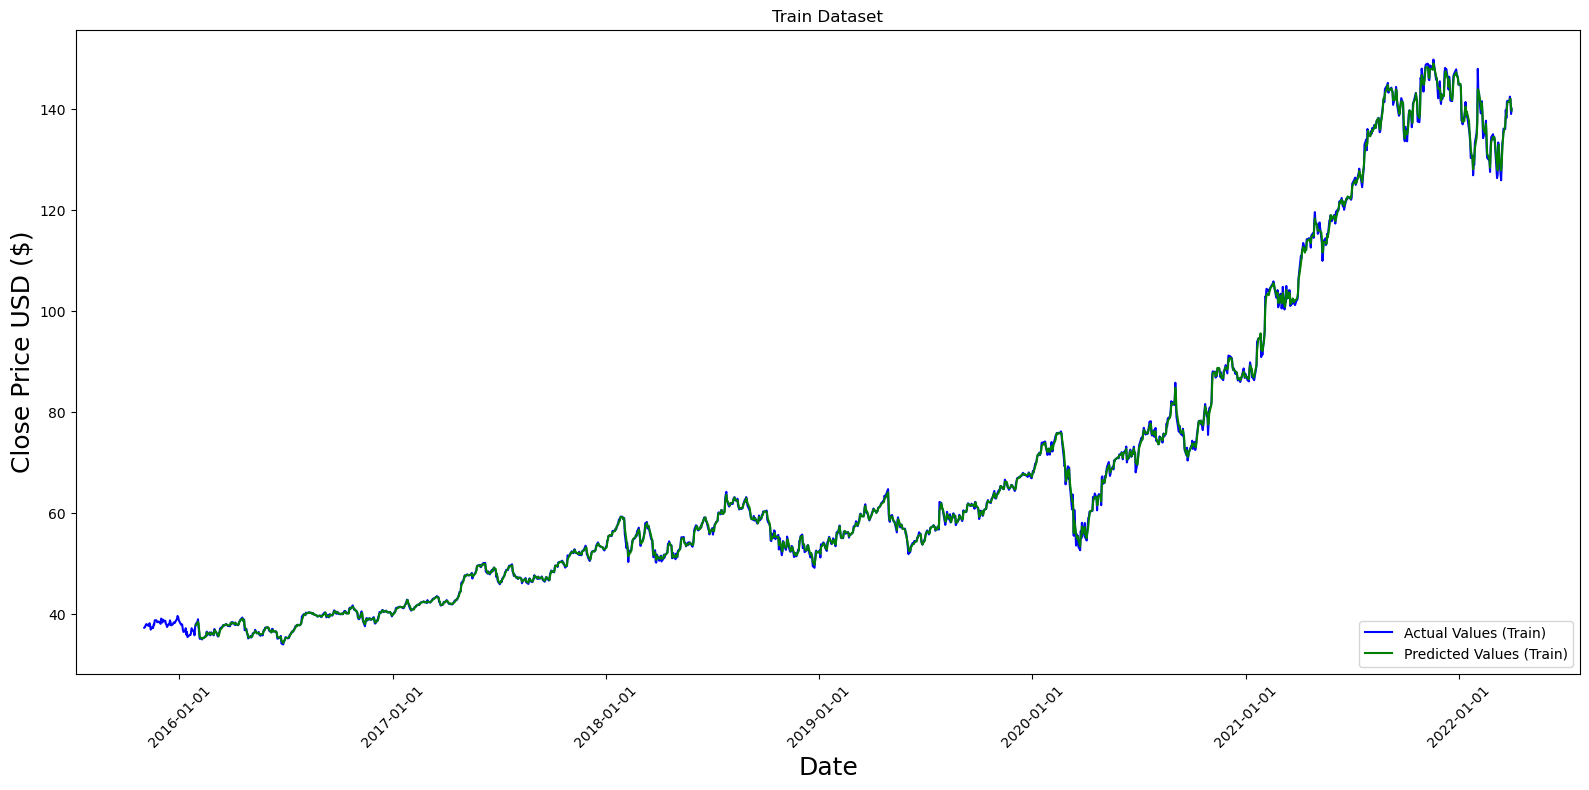

In [11]:
# Visualize the training data and predictions
df['Date'] = pd.to_datetime(df['Date'])
adjusted_train_dates = df['Date'][60:training_data_len]

plt.figure(figsize=(16, 8))
plt.title('Train Dataset')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(df['Date'][:training_data_len], df['Close'][:training_data_len], label='Actual Values (Train)', color='blue')
plt.plot(adjusted_train_dates, train_predictions, label='Predicted Values (Train)', color='green')

plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Forecasting the Next 365 Days

In [12]:
# Forecast the next 365 days
last_60_days = scaled_data[-60:]
predicted_prices = []

for i in range(365):
    # Reshape the input for Random Forest (2D array)
    X_pred_scaled = last_60_days.reshape(1, -1)
    
    # Make a prediction
    pred_price_scaled = model.predict(X_pred_scaled)
    
    # Append the predicted price
    predicted_prices.append(pred_price_scaled[0])
    
    # Update the last_60_days array
    last_60_days = np.append(last_60_days, pred_price_scaled)[1:].reshape(-1, 1)

# Scale back the predictions to the original price scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Generate prediction dates and print the predictions
last_date = pd.to_datetime(df['Date'].iloc[-1])
prediction_dates = [last_date + pd.Timedelta(days=x + 1) for x in range(365)]
predicted_prices = predicted_prices.flatten()

for i in range(len(prediction_dates)):
    print(f"Predicted closing price for {prediction_dates[i].date()}: ${predicted_prices[i]:.2f}")

Predicted closing price for 2023-11-09: $130.95
Predicted closing price for 2023-11-10: $129.43
Predicted closing price for 2023-11-11: $129.22
Predicted closing price for 2023-11-12: $129.74
Predicted closing price for 2023-11-13: $129.53
Predicted closing price for 2023-11-14: $129.50
Predicted closing price for 2023-11-15: $130.00
Predicted closing price for 2023-11-16: $130.06
Predicted closing price for 2023-11-17: $129.56
Predicted closing price for 2023-11-18: $129.66
Predicted closing price for 2023-11-19: $129.81
Predicted closing price for 2023-11-20: $129.56
Predicted closing price for 2023-11-21: $129.74
Predicted closing price for 2023-11-22: $129.78
Predicted closing price for 2023-11-23: $129.64
Predicted closing price for 2023-11-24: $129.60
Predicted closing price for 2023-11-25: $129.79
Predicted closing price for 2023-11-26: $129.62
Predicted closing price for 2023-11-27: $129.69
Predicted closing price for 2023-11-28: $129.71
Predicted closing price for 2023-11-29: 

### Visualize the Test Data and 365-Day Forecast

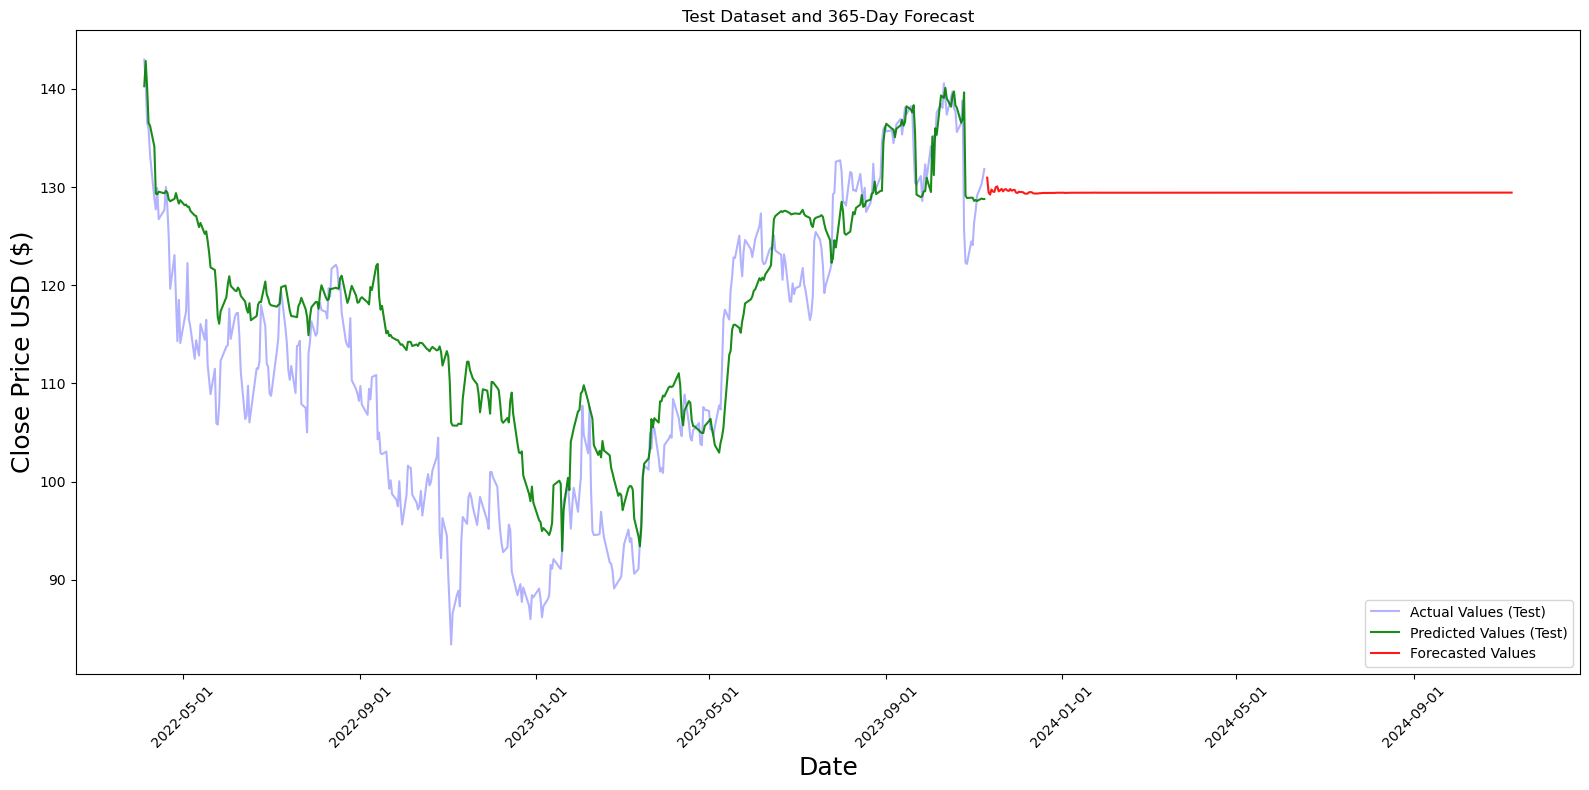

In [13]:
# Prepare the dates for forecasting by extending the existing dates array
forecast_dates = [df['Date'].iloc[-1] + pd.Timedelta(days=x + 1) for x in range(1, 366)]

plt.figure(figsize=(16, 8))
plt.title('Test Dataset and 365-Day Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(df['Date'][training_data_len:], y_test, label='Actual Values (Test)', color='Blue', alpha=0.3)
plt.plot(df['Date'][training_data_len:], test_predictions, label='Predicted Values (Test)', color='green', alpha=0.9)
plt.plot(forecast_dates, predicted_prices, label='Forecasted Values', color='red', alpha=0.9)

plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()